In [1]:
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import numpy as np
import os

BASE_DIR = '/home/saeidnp/research/video-diffusion/'

In [2]:
import wandb


class IdentityDict(dict):
    def __init__(self, d):
        for k, v in d.items():
            self[k] = v
    def __getitem__(self, k):
        if k in self:
            return super().__getitem__(k)
        else:
            return k

nice_mode_names = IdentityDict({
    'autoreg': 'Autoregressive',
    'adaptive-autoreg': 'Adaptive autoregressive',
    'adaptive-hierarchy-2': 'Adaptive hierarchy-2',
    'independent': 'Only original observations',
    'mixed-autoreg-independent': 'Mixed',
    'hierarchy-2': 'Hierarchy-2',
    'hierarchy-3': 'Hierarchy-3',
    'hierarchy-4': 'Hierarchy-4',
    'hierarchy-5': 'Hierarchy-5',
    'really-independent': 'Independent',
    'cwvae': 'CWVAE',
    'differently-spaced-groups': 'Training distribution',
})


def parse_run(path):
    relative_path = Path(str(path).replace(BASE_DIR, ""))
    if "cwvae" in str(relative_path):
        results, *subdirs, ckpt_name, _ = relative_path.parts
        inference_mode = "cwvae_20_10_None_36"
        wandb_id = "none"
    else:
        results, *subdirs, wandb_id, ckpt_name, inference_mode, _ = relative_path.parts
    assert results == 'results', f"expected 'results' to be equal to 'results' (got {results})"
    #print(inference_mode)
    mode, max_frames, step_size, T, obs_length = inference_mode.split('_')
    max_frames, step_size, T, obs_length = map(eval, [max_frames, step_size, T, obs_length])
    mode = nice_mode_names[mode]
    return dict(subdirs=subdirs, wandb_id=wandb_id, ckpt_name=ckpt_name,
                mode=mode, max_frames=max_frames, step_size=step_size, T=T, obs_length=obs_length)

def pad_to_len(s, l):
    return s + ' '*max(0, l-len(s))

def directory(path):
    return path if path.is_dir() else path.parent

def first_n(array, n):
    assert len(array) >= n
    return array[:n]

def format_mean_std(mean, std, n=None):
    s = f"{mean:.2f} +- {std:.3f}"
    if n is not None:
        s += f" ({n} seeds)"
    return s


class DB:
    def __init__(self, data=[]):
        if len(data) == 0:
            self.data = []
            for path in self.get_dirs():
                print(path)
                self.add_from_path(path)
        else:
            self.data = data
            
    def add_from_path(self, path):
        self.data.append({"path": path, "config": parse_run(path), **self.get_data(path)})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __iter__(self):
        return iter(self.data)

    def query(self, **kwargs):
        return ExpDB([x for x in self.data if all([x["config"][k] == v for (k,v) in kwargs.items()])])

    def sort(self, keys):
        if isinstance(keys, str):
            self.sort([keys])
        self.data.sort(key=lambda x: [x["config"][k] for k in keys])
        
    def get_sorted(self, keys):
        if isinstance(keys, str):
            return self.get_sorted([keys])
        return ExpDB(data=sorted(self.data, key=lambda x: [x["config"][k] for k in keys]))

    def print_config(self):
        for x in self.data:
            print(x["config"])
            
    def get_data(self, path):
        raise NotImplementedError


class ElboDB(DB):
    
    def get_dirs(self):
        paths = Path(BASE_DIR).glob('results/**/elbos/')
        return [p for p in paths if "optimal" not in str(p)]
    
    def get_data(self, path):
        i = 0
        while os.path.exists(path / f"elbo_{i}.pkl"):
            data_i = pickle.load(open(path / f"elbo_{i}.pkl", 'rb'))
            if i == 0:
                data = {k: [] for k in data_i}
            for k in data:
                data[k].append(data_i[k])
            i += 1
        if i == 0:
            print('WARNING: failed', str(path))
            raise Exception
        return {'data': {k: np.stack(v, axis=0) for k, v in data.items()}}


class MetricDB(DB):

    def get_dirs(self):
        paths = Path(BASE_DIR).glob('results/**/metrics_*.pkl')  
        return [p for p in paths if "optimal" not in str(p)]

    def get_data(self, path):
        fname = path.parts[-1]
        n_videos, n_samples, video_length = fname.split('_')[1].split('.')[0].split('-')
        return {'data': pickle.load(open(path, "rb")), 'n_videos': n_videos,
                'n_samples': n_samples, 'video_length': video_length}

In [3]:
#elbo_db = ElboDB()
metric_db = MetricDB()

/home/saeidnp/research/video-diffusion/results/cwvae-minerl/final-2-model/metrics_100-5-500.pkl
/home/saeidnp/research/video-diffusion/results/cwvae-minerl/final-1-model/metrics_100-5-500.pkl
/home/saeidnp/research/video-diffusion/results/carla-google-fs4/17u19ihi/ema_0.9999_1000000/google_None_None_None_36/metrics_100-1-1000.pkl
/home/saeidnp/research/video-diffusion/results/carla-google-fs4/17u19ihi/ema_0.9999_450000/google_None_None_None_36/metrics_100-1-1000.pkl
/home/saeidnp/research/video-diffusion/results/minerl-final-850k/2qlmlyit/ema_0.9999_850000/autoreg_20_10_None_36/metrics_100-5-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-final-850k/2qlmlyit/ema_0.9999_850000/adaptive-hierarchy-2_20_10_None_36/metrics_100-5-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-final-850k/2qlmlyit/ema_0.9999_850000/hierarchy-3_20_10_None_36/metrics_100-5-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-final-850k/2qlmlyit/ema_0.9999_850000/mixed-autore

/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/25bq1cac/ema_0.9999_500000_respace250/hierarchy-2_10_5_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/8zjcrvdx/ema_0.9999_500000/hierarchy-2_20_10_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/8zjcrvdx/ema_0.9999_500000/hierarchy-2_10_5_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/8zjcrvdx/ema_0.9999_500000_respace250/hierarchy-2_10_5_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/3mnvpjlf/ema_0.9999_500000_respace250/hierarchy-2_10_5_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/3mnvpjlf/ema_0.9999_500000/hierarchy-2_10_5_None_36/metrics_100-1-500.pkl
/home/saeidnp/research/video-diffusion/results/minerl-rpe-net-ablation/3mnvpjlf/ema_0.9999_50000

### MineRL

## And test FVDs for the same runs

In [4]:
minerl_inf_mode_db = [i for i in metric_db if 'minerl-final-850k' in i['config']['subdirs']]
minerl_google = [x for x in metric_db if "minerl-google-fs4" in x['config']['subdirs'] and "1100000" in x['config']['ckpt_name']]
minerl_cwvae = [x for x in metric_db if "cwvae-minerl" in x['config']['subdirs']]
#minerl_inf_mode_elbo_db = [i for i in elbo_db if 'minerl-final-850k' in i['config']['subdirs']]

mazes_inf_mode_db = [i for i in metric_db if 'mazes-final-950k' in i['config']['subdirs']]
mazes_google = [x for x in metric_db if "mazes-google-fs4" in x['config']['subdirs'] and "1100000" in x['config']['ckpt_name']]
mazes_cwvae = [x for x in metric_db if "cwvae-mazes" in x['config']['subdirs']]
#mazes_inf_mode_elbo_db = [i for i in elbo_db if 'mazes-final-950k' in i['config']['subdirs']]

carla_inf_mode_db = [i for i in metric_db if 'carla-final' in i['config']['subdirs']]
carla_google = [x for x in metric_db if "carla-google-fs4" in x['config']['subdirs']]
carla_cwvae = [x for x in metric_db if "cwvae-carla" in x['config']['subdirs']]

In [5]:
def print_mode_fvds(db, add_path=False):
    to_show = {}
    for run in db:
        metrics = run['data']['fvd']
        inf_mode = run['config']['mode']
        string = f"{format_mean_std(metrics.mean(), metrics.std()/np.sqrt(len(metrics)-1), len(metrics))} - {inf_mode}"
        if add_path:
            string += f' ({"/".join(run["path"].parts[-3:])})'
        to_show[string] = metrics.mean()
    for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
        print(label)
        
print('Mazes')
print_mode_fvds(mazes_inf_mode_db)
print_mode_fvds(mazes_cwvae, add_path=True)
print_mode_fvds(mazes_google, add_path=True)

        
print('\nMineRL')
print_mode_fvds(minerl_inf_mode_db)
print_mode_fvds(minerl_cwvae, add_path=True)
print_mode_fvds(minerl_google, add_path=True)


print('\nCARLA')
print_mode_fvds(carla_inf_mode_db)
print_mode_fvds(carla_cwvae, add_path=True)
print_mode_fvds(carla_google, add_path=True)

Mazes
53.11 +- 1.063 (5 seeds) - Hierarchy-2
53.70 +- 1.886 (5 seeds) - Hierarchy-3
54.27 +- nan (1 seeds) - like-google
54.97 +- 1.426 (5 seeds) - Adaptive hierarchy-2
64.49 +- 1.948 (5 seeds) - Mixed
86.44 +- 2.589 (5 seeds) - Autoregressive
836.68 +- 3.997 (5 seeds) - CWVAE (cwvae-mazes/final-1-110000/metrics_100-5-300.pkl)
984.52 +- 5.429 (5 seeds) - CWVAE (cwvae-mazes/final-2-110000/metrics_100-5-300.pkl)
66.73 +- 1.488 (5 seeds) - google (ema_0.9999_1100000/google_None_None_None_36/metrics_100-5-300.pkl)

MineRL
252.30 +- nan (1 seeds) - like-google
267.03 +- 4.026 (5 seeds) - Mixed
274.89 +- 7.660 (5 seeds) - Hierarchy-2
277.85 +- nan (1 seeds) - like-google
280.89 +- 10.174 (5 seeds) - Autoregressive
311.39 +- 6.826 (5 seeds) - Hierarchy-3
315.77 +- 8.899 (5 seeds) - Adaptive hierarchy-2
1572.72 +- 2.278 (5 seeds) - CWVAE (cwvae-minerl/final-1-model/metrics_100-5-500.pkl)
1578.77 +- 7.378 (5 seeds) - CWVAE (cwvae-minerl/final-2-model/metrics_100-5-500.pkl)
127.00 +- nan (1 seed

/home/saeidnp/.virtualenvs/video-diffusion/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [6]:
def print_mode_lpips(db, seeds=None, add_path=False):
    to_show = {}
    for run in db:
        if "lpips" not in run['data']:
            continue
        metrics = run['data']['lpips']
        inf_mode = run['config']['mode']
        if seeds is not None:
            metrics = metrics[:, :seeds]
            if metrics.shape[1] != seeds:
                print("Not enough seeds")
                continue
        num_seeds = metrics.shape[1]
        metrics = metrics.min(axis=1) # Per-frame minimum
        #metrics = metrics.mean(axis=-1).min(axis=-1) # Per-video minimum
        string = f"{format_mean_std(metrics.mean(), metrics.std()/np.sqrt(len(metrics)-1), num_seeds)} - {inf_mode}"
        if add_path:
            string += f' ({"/".join(run["path"].parts[-3:])})'
        to_show[string] = metrics.mean()
    for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
        print(label)
        
print('Mazes')
print_mode_lpips(mazes_inf_mode_db, seeds=5)
print_mode_lpips(mazes_cwvae, seeds=5, add_path=True)
print_mode_lpips(mazes_google, seeds=5, add_path=True)


print('\nMineRL')
print_mode_lpips(minerl_inf_mode_db, seeds=5)
print_mode_lpips(minerl_cwvae, seeds=5, add_path=True)
print_mode_lpips(minerl_google, seeds=5, add_path=True)

        
print('\nCARLA')
print_mode_lpips(carla_inf_mode_db, seeds=1)
print_mode_lpips(carla_cwvae, seeds=1, add_path=True)
print_mode_lpips(carla_google, seeds=1, add_path=True)

Mazes
Not enough seeds
0.26 +- 0.013 (5 seeds) - Hierarchy-3
0.26 +- 0.013 (5 seeds) - Adaptive hierarchy-2
0.27 +- 0.013 (5 seeds) - Hierarchy-2
0.27 +- 0.014 (5 seeds) - Mixed
0.30 +- 0.014 (5 seeds) - Autoregressive
0.31 +- 0.013 (5 seeds) - CWVAE (cwvae-mazes/final-2-110000/metrics_100-5-300.pkl)
0.31 +- 0.012 (5 seeds) - CWVAE (cwvae-mazes/final-1-110000/metrics_100-5-300.pkl)
0.28 +- 0.013 (5 seeds) - google (ema_0.9999_1100000/google_None_None_None_36/metrics_100-5-300.pkl)

MineRL
Not enough seeds
Not enough seeds
0.28 +- 0.015 (5 seeds) - Hierarchy-3
0.28 +- 0.016 (5 seeds) - Mixed
0.28 +- 0.015 (5 seeds) - Hierarchy-2
0.29 +- 0.015 (5 seeds) - Adaptive hierarchy-2
0.29 +- 0.016 (5 seeds) - Autoregressive
0.46 +- 0.020 (5 seeds) - CWVAE (cwvae-minerl/final-1-model/metrics_100-5-500.pkl)
0.47 +- 0.020 (5 seeds) - CWVAE (cwvae-minerl/final-2-model/metrics_100-5-500.pkl)
Not enough seeds
0.29 +- 0.015 (5 seeds) - google (ema_0.9999_1100000/google_None_None_None_36/metrics_100-5-5

In [16]:
def print_mode_str(db, mode_name, seeds=None, add_path=False):
    to_show = {}
    for run in db:
        if mode_name not in run['data']:
            continue
        metrics = run['data'][mode_name]
        inf_mode = run['config']['mode']
        if seeds is not None:
            metrics = metrics[:, :seeds]
            if metrics.shape[1] != seeds:
                print("Not enough seeds")
                continue
        num_seeds = metrics.shape[1]
        metrics = metrics.max(axis=1) # Per-frame maximum
        #metrics = metrics.mean(axis=-1).max(axis=-1) # Per-video maximum
        string = f"{format_mean_std(metrics.mean(), metrics.std()/np.sqrt(len(metrics)-1), num_seeds)} - {inf_mode}"
        if add_path:
            string += f' ({"/".join(run["path"].parts[-3:])})'
        to_show[string] = metrics.mean()
    for label, elbo in sorted(to_show.items(), key=lambda x: x[1]):
        print(label)
        
print('Mazes - SSIM')
print_mode_str(mazes_inf_mode_db, mode_name="ssim", seeds=5)
print_mode_str(mazes_cwvae, mode_name="ssim", seeds=5, add_path=True)
print_mode_str(mazes_google, mode_name="ssim", seeds=5, add_path=True)


print('\nMineRL - SSIM')
print_mode_str(minerl_inf_mode_db, mode_name="ssim", seeds=5)
print_mode_str(minerl_cwvae, mode_name="ssim", seeds=5, add_path=True)
print_mode_str(minerl_google, mode_name="ssim", seeds=5, add_path=True)

        
print('\nCARLA - SSIM')
print_mode_str(carla_inf_mode_db, mode_name="ssim", seeds=1)
print_mode_str(carla_cwvae, mode_name="ssim", seeds=1, add_path=True)
print_mode_str(carla_google, mode_name="ssim", seeds=1, add_path=True)
        
print('Mazes - PSNR')
print_mode_str(mazes_inf_mode_db, mode_name="psnr", seeds=5)
print_mode_str(mazes_cwvae, mode_name="psnr", seeds=5, add_path=True)
print_mode_str(mazes_google, mode_name="psnr", seeds=5, add_path=True)


print('\nMineRL - PSNR')
print_mode_str(minerl_inf_mode_db, mode_name="psnr", seeds=5)
print_mode_str(minerl_cwvae, mode_name="psnr", seeds=5, add_path=True)
print_mode_str(minerl_google, mode_name="psnr", seeds=5, add_path=True)

        
print('\nCARLA - PSNR')
print_mode_str(carla_inf_mode_db, mode_name="psnr", seeds=1)
print_mode_str(carla_cwvae, mode_name="psnr", seeds=1, add_path=True)
print_mode_str(carla_google, mode_name="psnr", seeds=1, add_path=True)

Mazes - SSIM
Not enough seeds
0.60 +- 0.010 (5 seeds) - Autoregressive
0.61 +- 0.011 (5 seeds) - Mixed
0.61 +- 0.011 (5 seeds) - Hierarchy-2
0.62 +- 0.011 (5 seeds) - Adaptive hierarchy-2
0.62 +- 0.011 (5 seeds) - Hierarchy-3
0.64 +- 0.010 (5 seeds) - CWVAE (cwvae-mazes/final-2-110000/metrics_100-5-300.pkl)
0.64 +- 0.010 (5 seeds) - CWVAE (cwvae-mazes/final-1-110000/metrics_100-5-300.pkl)
0.61 +- 0.011 (5 seeds) - google (ema_0.9999_1100000/google_None_None_None_36/metrics_100-5-300.pkl)

MineRL - SSIM
Not enough seeds
Not enough seeds
0.53 +- 0.020 (5 seeds) - Autoregressive
0.53 +- 0.019 (5 seeds) - Adaptive hierarchy-2
0.54 +- 0.020 (5 seeds) - Mixed
0.54 +- 0.019 (5 seeds) - Hierarchy-2
0.54 +- 0.019 (5 seeds) - Hierarchy-3
0.59 +- 0.017 (5 seeds) - CWVAE (cwvae-minerl/final-1-model/metrics_100-5-500.pkl)
0.60 +- 0.017 (5 seeds) - CWVAE (cwvae-minerl/final-2-model/metrics_100-5-500.pkl)
Not enough seeds
0.54 +- 0.020 (5 seeds) - google (ema_0.9999_1100000/google_None_None_None_36/m

In [65]:
from numpy import array

a = array([54.80147818, 51.68201544, 56.26377283, 50.41206905, 52.407861  ])
print(a.mean(), a.std())

a = array([78.40920528, 91.71340571, 92.43377901, 84.29541665, 85.32933231])
print(a.mean(), a.std())

53.1134393 2.1268894114470154
86.43622779199998 5.1780422507487955


## And LPIPS vs distance for the same runs

In [66]:
_default_label_func = lambda x: f"{x['path'].parent.name}/{x['path'].stem}"


from scipy import stats
def smooth(x, std):
    # smooth a 1-D numpy array x
    gaussian_filter = stats.norm(0., 5.).pdf(np.arange(-5*std, 5*std))
    unnormed = np.convolve(x, gaussian_filter, 'same')
    norm_const = np.convolve(np.ones_like(x), gaussian_filter, 'same')
    return unnormed / norm_const


def do_plot(db, ax, mode, errorbar=True,
            label_func=_default_label_func,
            agg_mode="best",
            baseline_metrics=None, set_color=None,
            smooth_std=None, verbose=True):
    
    def agg_predictions(metric, agg_mode):
        assert agg_mode in ["best", "best_avg", "mean", "random"]
        best_fn = {"ssim": "max", "psnr": "max", "lpips": "min"}[mode]

        if agg_mode == "best":
            metric = getattr(metric[:, :2], best_fn)(axis=1)
        elif agg_mode == "best_avg":
            # Finding the order within samples wrt avg metric across time.
            order_metric = np.argsort(np.mean(metric, -1), axis=-1)
            assert best_fn in ["max", "min"]
            if best_fn == "max":
                metric = np.stack([metric[i, order[-1]] for (i, order) in enumerate(order_metric)])
            else:
                metric = np.stack([metric[i, order[0]] for (i, order) in enumerate(order_metric)])
        elif agg_mode == "random":
            metric = metric[:, 0, :]
        elif agg_mode == "mean":
            metric = metric.mean(axis=1)
        else:
            raise ValueError(f"Unknown aggregation mode {agg_mode}")
        return metric
    
    labels_seen = set()
    assert mode in ["ssim", "psnr", "lpips"]
    if label_func is None:
        label_func = lambda x: None
    for exp_data in db:
        path = str(exp_data["path"])
        metrics = exp_data["metrics"]
        if mode not in metrics:
            if verbose:
                print(f"Metrics {mode} not found in {path}")
            continue
        metric = agg_predictions(metrics[mode], agg_mode)

        mean = metric.mean(axis=0)
        if smooth_std is not None:
            mean = smooth(mean, smooth_std)
        std = metric.std(axis=0)
        label = None
        ls = '-'
        label = label_func(exp_data)
        
        color = set_color(path) if set_color is not None else None

        ax.plot(mean, label=None if label in labels_seen else label, color=color, ls=ls)
        labels_seen.add(label)
        if errorbar:
            ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.1)
    ax.grid("on")

NameError: name 'metrics_db' is not defined

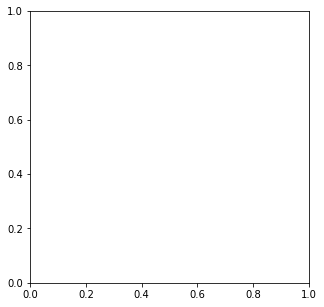

In [67]:
def set_color(path):
    if 'mixed' in path:
        return 'r'
    elif 'autoreg' in path:
        return 'b'
    elif 'really-independent' in path:
        return 'k'
    elif 'independent' in path:
        return 'g'
    elif 'cwvae' in path:
        return 'y'
def lpips_label_func(run):
    path = run['path']
    id = directory(path).parts[-2]
    return nice_mode_names[Path(directory(path)).parts[-1].split('_')[0]]
fig, ax = plt.subplots(figsize=(5, 5))
do_plot(metrics_db, ax, mode='lpips', errorbar=False, set_color=set_color,
       label_func=lpips_label_func, verbose=False, smooth_std=5)
ax.set_xlabel('Distance from originally observed frames')
ax.set_ylabel('Minimum LPIPS distance from ground truth (2 samples)')
ax.legend()

## FVD for various inference modes

In [ ]:
#fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in inf_modes_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
#fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
#for fvd, run in fvds_runs:
#    fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#    id = run['path'].parts[-3]
#    print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 40)} Trained with {run_names[id]}")

## FVD for ablations

In [ ]:
# fvds_runs = [(run['metrics']['fvd'].mean(), run) for run in ablations_db if 'fvd' in run['metrics'] and run['config']['T_pred']==300]
# fvds_runs = sorted(fvds_runs, key=lambda x: x[0])
# for fvd, run in fvds_runs:
#     fvd_str = f"{fvd:.2f} +- {run['metrics']['fvd'].std():.1f} ({run['metrics']['fvd'].shape[0]} seeds)"
#     id = run['path'].parts[-3]
#     print(f"{pad_to_len(fvd_str, 14)} - {pad_to_len(label_func(run), 30)} Trained with {run_names[id]}")

In [ ]:
mixed_db = [thing for thing in metrics_db if 'mixed' in str(thing['path'])]
autoreg_db = [thing for thing in metrics_db if 'autoreg_' in str(thing['path']) and 'mixed' not in str(thing['path'])]
independent_db = [thing for thing in metrics_db if 'independent_' in str(thing['path']) and 'mixed' not in str(thing['path'])]

## Autoreg

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(autoreg_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Mixed

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(mixed_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()

## Independent

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
do_plot(independent_db, ax, mode='lpips', errorbar=False, set_color=None)
ax.legend()